Epoch [10/500], Loss: 8.5196
Epoch [20/500], Loss: 3.7196
Epoch [30/500], Loss: 2.5800
Epoch [40/500], Loss: 2.1889
Epoch [50/500], Loss: 1.9603
Epoch [60/500], Loss: 1.7425
Epoch [70/500], Loss: 1.5033
Epoch [80/500], Loss: 1.2677
Epoch [90/500], Loss: 1.0576
Epoch [100/500], Loss: 0.9281
Epoch [110/500], Loss: 0.8406
Epoch [120/500], Loss: 0.7825
Epoch [130/500], Loss: 0.7411
Epoch [140/500], Loss: 0.7041
Epoch [150/500], Loss: 0.6774
Epoch [160/500], Loss: 0.6544
Epoch [170/500], Loss: 0.6238
Epoch [180/500], Loss: 0.6019
Epoch [190/500], Loss: 0.5876
Epoch [200/500], Loss: 0.5597
Epoch [210/500], Loss: 0.5399
Epoch [220/500], Loss: 0.5263
Epoch [230/500], Loss: 0.5128
Epoch [240/500], Loss: 0.5026
Epoch [250/500], Loss: 0.4915
Epoch [260/500], Loss: 0.4731
Epoch [270/500], Loss: 0.4590
Epoch [280/500], Loss: 0.4345
Epoch [290/500], Loss: 0.4233
Epoch [300/500], Loss: 0.4018
Epoch [310/500], Loss: 0.3929
Epoch [320/500], Loss: 0.3865
Epoch [330/500], Loss: 0.3664
Epoch [340/500], Lo

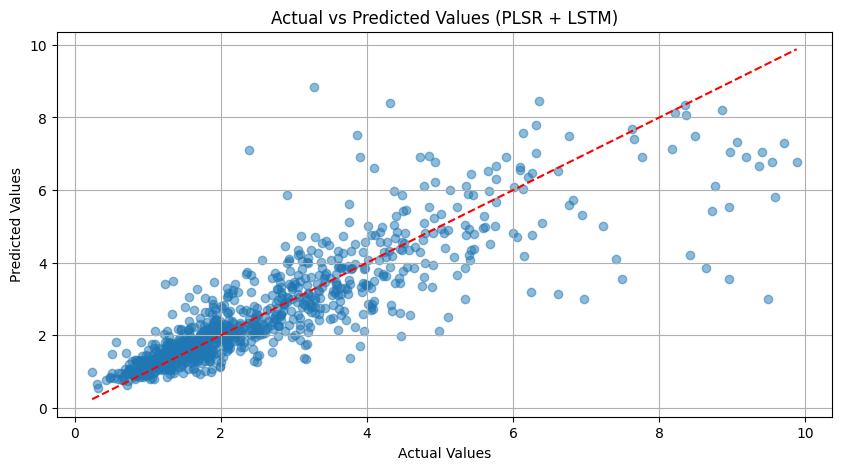

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# Load your cleaned data
data = pd.read_csv('data.csv')
data = data.drop(columns=['Unnamed: 0'])

# Define target variable
target = 'oc_iso.10694_w.pct'

X1 = data.drop(columns=[target]).values
y1 = data[target].values

# Create a boolean mask where y values are <= 10
mask = y1 <= 10

# Apply mask to filter X and y
X = X1[mask]
y = y1[mask]





# Normalize features
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the PLS Regression model for dimensionality reduction
n_components = min(75, X_train.shape[1])  # Adjust based on your data; 10 is an example
pls = PLSRegression(n_components=n_components)

# Fit PLSR on the training data and transform both training and test sets
#X_train_pls = pls.fit_transform(X_train, y_train)[0]
#X_test_pls = pls.transform(X_test)# check using traning data


# Fit PLSR on the training data and transform the training set
X_train_pls, _ = pls.fit_transform(X_train, y_train)

# Transform the test set using the fitted model (trained on the training set)
X_test_pls = pls.transform(X_test)


#pls  scores loading regression coeffieicent latent  variables , 

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_pls, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_pls, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward pass through LSTM layer
        out, _ = self.lstm(x, (h0, c0))
        # Select the last time step
        out = out[:, -1, :]
        # Forward pass through fully connected layer
        out = self.fc(out)
        return out

# Hyperparameters
input_size = X_train_pls.shape[1]  # Number of features after PLSR
hidden_size = 256
output_size = 1  # For regression
num_layers = 5
num_epochs = 500
learning_rate = 0.001

# Initialize the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    
    # Forward pass
    outputs = model(X_train_tensor.unsqueeze(1))  # Add sequence dimension
    loss = criterion(outputs.squeeze(), y_train_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    # Make predictions on the test set
    predictions = model(X_test_tensor.unsqueeze(1)).squeeze()
    
    # Calculate test loss
    test_loss = criterion(predictions, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')
    
    # Convert predictions and y_test to numpy arrays
    y_pred_np = predictions.numpy()
    y_test_np = y_test_tensor.numpy()

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test_np, y_pred_np))
    print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
    
    # Calculate correlation coefficient
    correlation, _ = pearsonr(y_test_np, y_pred_np)
    print(f'Correlation coefficient: {correlation:.4f}')
    
    # Plot actual vs. predicted values
    plt.figure(figsize=(10, 5))
    plt.scatter(y_test_np, y_pred_np, alpha=0.5)
    plt.plot([min(y_test_np), max(y_test_np)], [min(y_test_np), max(y_test_np)], color='red', linestyle='--')  # Perfect prediction line
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values (PLSR + LSTM)')
    plt.grid(True)
    plt.show()
